Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.

For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' 

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.metrics as metrics

## 1. Preparing our dataset

In [134]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv("datasets/fma-rock-vs-hiphop.csv")

# Read in track metrics with the features
echonest_metrics = pd.read_json("datasets/echonest-metrics.json", precise_float=True)
tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [135]:
# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], on='track_id')
# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


In [136]:
nan_hiphop_counts = echo_tracks["genre_top"].value_counts(dropna=False)

# Display the counts
print(nan_hiphop_counts)

genre_top
Rock       3892
Hip-Hop     910
Name: count, dtype: int64


## 2. Pairwise relationships between continuous variables
<p>We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:</p>
<ul>
<li>To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).</li>
<li>When our datasets are very large, using fewer features can drastically speed up our computation time.</li>
</ul>
<p>To get a sense of whether there are any strongly correlated features in our data, we will create a correlation matrix

In [137]:
# Create a correlation matrix
numeric_columns = echo_tracks.select_dtypes(include=['number']).columns
numeric_data = echo_tracks[numeric_columns]
corr_metrics = numeric_data.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


## 3. Splitting our data
<p>As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particularly strong correlations between our features, we can now split our data into an array containing our features, and another containing the labels - the genre of the track. </p>


In [138]:
from sklearn.model_selection import train_test_split

# Create features
features = echo_tracks.drop(["track_id", "genre_top"] , axis = 1)
# Create labels
labels = echo_tracks["genre_top"]


# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state = 10)

# saving back of original train and test data 
train_features_or = train_features
test_features_or = test_features
train_labels_or = train_labels
test_labels_or = test_labels

In [139]:
print(train_features.shape)
print(test_features.shape)

(3601, 8)
(1201, 8)


## 4. Normalizing the feature data
<p>As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called <strong>principal component analysis (PCA)</strong>. </p>
<p>It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes. </p>
<p>However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our train and test features. 
    
Performing <em>standardization</em> - all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score). </p>

In [140]:
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
# scaled_features = scaler.fit_transform(features)
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.fit_transform(test_features)


## 5. Principal Component Analysis on our scaled data
<p>Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use <strong>scree-plots</strong> and <strong>cumulative explained ratio plots</strong> to find the number of components to use in further analyses.</p>
<p><b>Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.</b></p>

In [141]:
from sklearn.decomposition import PCA
#... YOUR CODE ...

# Get the explained variance ratios from PCA using all features
pca = PCA()

pca.fit(scaled_train_features)

exp_variance = pca.explained_variance_ratio_
num_components = pca.n_components_

print(exp_variance)
print(num_components)


[0.23895983 0.18149129 0.13648392 0.13004899 0.1124591  0.08329047
 0.07040829 0.04685811]
8


Text(0.5, 0, 'Principal Component #')

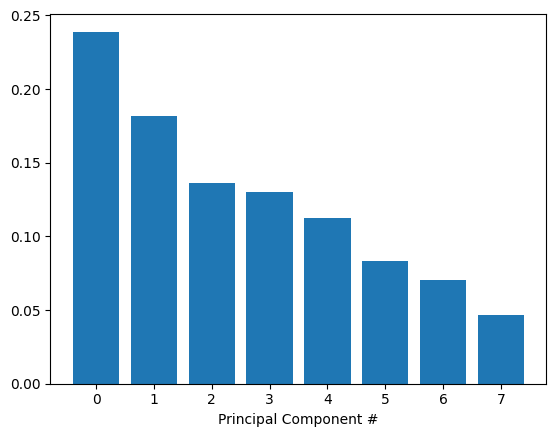

In [142]:
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(num_components), exp_variance)
ax.set_xlabel('Principal Component #')

## 6. Further visualization of PCA
<p>Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method. </p>
<p>Instead, we can also look at the <strong>cumulative explained variance plot</strong> to determine how many features are required to explain, say, about 85% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by 'rules of thumb'). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.</p>

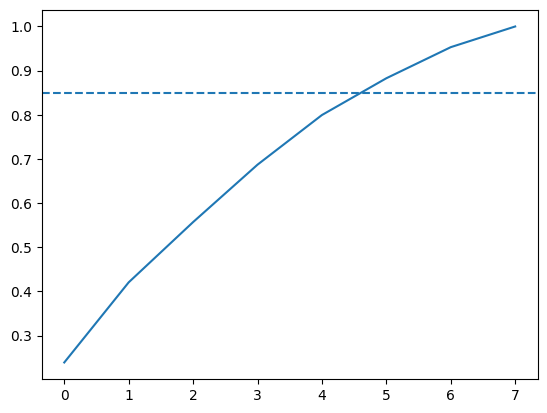

In [143]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(range(8),cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

## 7. Projecting on to our features
<p>We saw from the plot that 6 features (remember indexing starts at 0) can explain 85% of the variance! </p>
<p>Therefore, we can use 6 components to perform PCA and reduce the dimensionality of our train and test features.</p>

In [144]:
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(scaled_test_features)

print(train_pca.shape)

print(test_pca.shape)


(3601, 6)
(1201, 6)


## 8. Train a decision tree to classify genre
<p>Now we can use the lower dimensional PCA projection of the data to classify songs into genres. </p>
<p>Here, we will be using a algorithm known as a decision tree. 
Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to ultimately classify a data point into one of two or more categories. In addition to being easy to both use and interpret, decision trees allow us to visualize the 'logic flowchart' that the model generates from the training data.</p>

In [145]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, predictions, cmap_, class_labels=None):
    cm = confusion_matrix(y_test, predictions)
    
    custom_cmap = plt.get_cmap(cmap_)  # Use plt.get_cmap to get the colormap

    if class_labels:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot(cmap=custom_cmap)
    plt.show()

In [146]:
from sklearn.tree import DecisionTreeClassifier

# Train our decision tree
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_pca, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_pca)



In [147]:
# Evaluation

Tree_Accuracy_Score = accuracy_score(test_labels, pred_labels_tree)

Tree_JaccardIndex = jaccard_score(test_labels, pred_labels_tree, average='weighted')

Tree_F1_Score = f1_score(test_labels, pred_labels_tree, average='weighted')

Report_Tree = pd.DataFrame({
    'Metric': ['Accuracy_Score', 'JaccardIndex', 'F1_Score'],
    'Score': [Tree_Accuracy_Score, Tree_JaccardIndex, Tree_F1_Score]
})

print(Report_Tree)

           Metric     Score
0  Accuracy_Score  0.862614
1    JaccardIndex  0.769958
2        F1_Score  0.860636


## 9. Compare our decision tree with other algorithms
<p>Although our tree's performance is decent, it's a bad idea to immediately assume that it's therefore the perfect tool for this job -- there's always the possibility of other models that will perform even better! It's always a worthwhile idea to at least test a few other algorithms and find the one that's best for our data.</p>

<!-- <p><strong>logistic regression</strong>. Logistic regression makes use of what's called the logistic function to calculate the odds that a given data point belongs to a given class. Once we have both models, we can compare them on a few performance metrics, such as false positive and false negative rate (or how many points are inaccurately classified). </p> -->

In [148]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logisitic regression
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

In [149]:
# Evaluation

Logreg_Accuracy_Score = accuracy_score(test_labels,pred_labels_logit)

Logreg_JaccardIndex = jaccard_score(test_labels, pred_labels_logit, average='weighted')

Logreg_F1_Score = f1_score(test_labels, pred_labels_logit, average='weighted')

Report_logreg = pd.DataFrame({
    'Metric': ['Accuracy_Score', 'JaccardIndex', 'F1_Score'],
    'Score': [Logreg_Accuracy_Score, Logreg_JaccardIndex, Logreg_F1_Score]
})

print(Report_logreg)

           Metric     Score
0  Accuracy_Score  0.878435
1    JaccardIndex  0.785446
2        F1_Score  0.869318


In [150]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier


In [151]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
title = ""
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(train_pca, train_labels)
    pred_labels_knn=neigh.predict(test_pca)
    mean_acc[n-1] = metrics.accuracy_score(test_labels, pred_labels_knn)
    std_acc[n-1]=np.std(pred_labels_knn==test_labels)/np.sqrt(pred_labels_knn.shape[0])

mean_acc

array([0.8692756 , 0.85262281, 0.90258118, 0.89675271, 0.90008326,
       0.89841799, 0.9009159 , 0.89841799, 0.90174854])

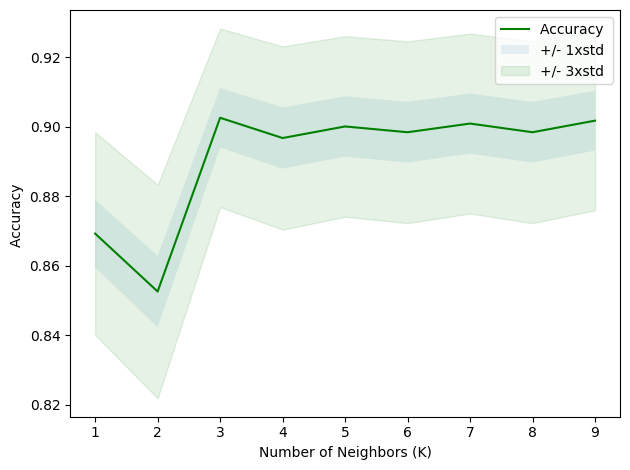

In [152]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [153]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.9025811823480433 with k= 3


In [154]:
k = 3
KNN = KNeighborsClassifier(n_neighbors = k)
KNN.fit(train_pca, train_labels)

pred_labels_knn = KNN.predict(test_pca)

In [155]:
# Evaluation

KNN_Accuracy_Score = accuracy_score(test_labels,pred_labels_knn)

KNN_JaccardIndex = jaccard_score(test_labels, pred_labels_knn, average='weighted')

KNN_F1_Score = f1_score(test_labels, pred_labels_knn, average='weighted')

Report_knn = pd.DataFrame({
    'Metric': ['Accuracy_Score', 'JaccardIndex', 'F1_Score'],
    'Score': [KNN_Accuracy_Score, KNN_JaccardIndex, KNN_F1_Score]
})

print(Report_knn)

           Metric     Score
0  Accuracy_Score  0.902581
1    JaccardIndex  0.825865
2        F1_Score  0.898737


In [156]:
from sklearn import svm

SVM = svm.SVC(kernel='rbf')
SVM.fit(train_pca, train_labels) 

pred_labels_svm = SVM.predict(test_pca)


In [157]:
# Evaluation

SVM_Accuracy_Score = accuracy_score(test_labels,pred_labels_svm)

SVM_JaccardIndex = jaccard_score(test_labels,pred_labels_svm, average='weighted')

SVM_F1_Score = f1_score(test_labels,pred_labels_svm, average='weighted')

Report_SVM = pd.DataFrame({
    'Metric': ['Accuracy_Score', 'JaccardIndex', 'F1_Score'],
    'Score': [SVM_Accuracy_Score, SVM_JaccardIndex, SVM_F1_Score]
})

print(Report_SVM)

           Metric     Score
0  Accuracy_Score  0.903414
1    JaccardIndex  0.823920
2        F1_Score  0.896651


### Comparision among the algorithm with evaluation metrics and visualization

In [158]:
# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)
class_rep_knn= classification_report(test_labels, pred_labels_knn)
class_rep_svm = classification_report(test_labels,pred_labels_svm)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)
print("K Near Neigbours : \n", class_rep_tree)
print("Support Vector Machine : \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.66      0.61      0.64       235
        Rock       0.91      0.92      0.92       966

    accuracy                           0.86      1201
   macro avg       0.78      0.77      0.78      1201
weighted avg       0.86      0.86      0.86      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.78      0.53      0.63       235
        Rock       0.89      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.84      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201

K Near Neigbours : 
               precision    recall  f1-score   support

     Hip-Hop       0.66      0.61      0.64       235
        Rock       0.91      0.92      0.92       966

    accuracy                           0.86      1201
   macro avg       0.78      0.77      0.78      1201
weighted avg 

Decision Tree : 


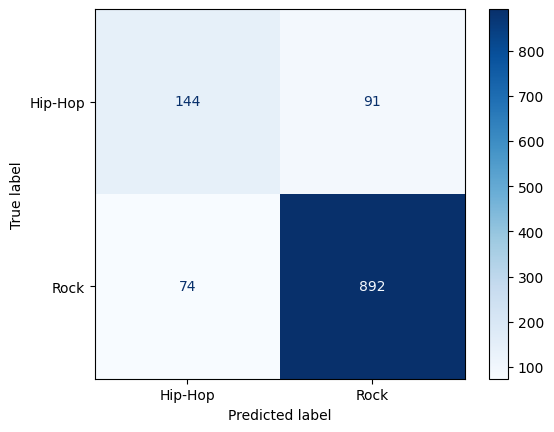

Logistic Regression : 


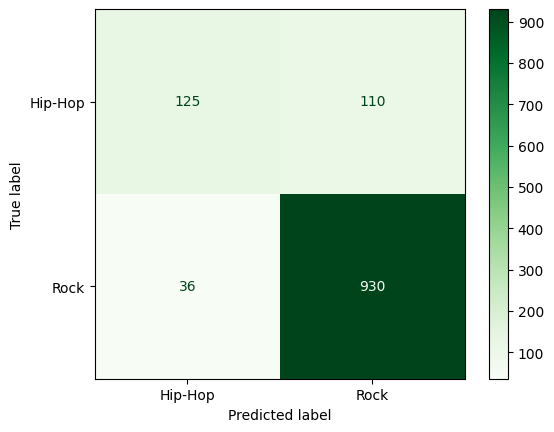

K Nearest Neighbours : 


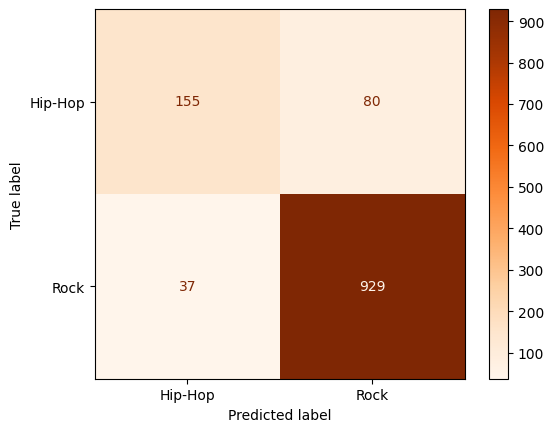

Support Vector Machine : 


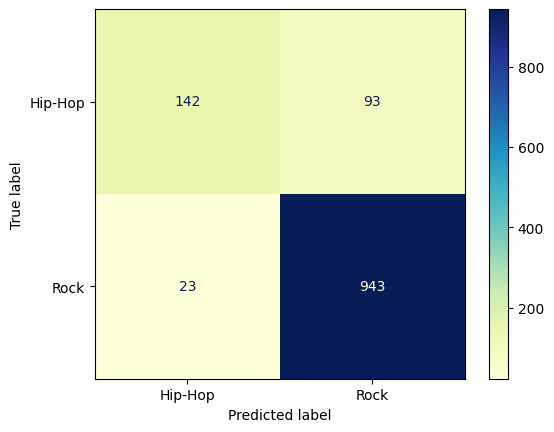

In [159]:
# plotting confusion matrix

print("Decision Tree : ")
plot_confusion_matrix(test_labels, pred_labels_tree, 'Blues', ["Hip-Hop", "Rock"])
print("Logistic Regression : ")
plot_confusion_matrix(test_labels, pred_labels_logit, 'Greens', ["Hip-Hop", "Rock"])
print("K Nearest Neighbours : ")
plot_confusion_matrix(test_labels, pred_labels_knn, 'Oranges', ["Hip-Hop", "Rock"])
print("Support Vector Machine : ")
plot_confusion_matrix(test_labels, pred_labels_svm, 'YlGnBu', ["Hip-Hop", "Rock"])

In [160]:
# Create DataFrames for each model's metrics
LR_metrics = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Accuracy': [Logreg_Accuracy_Score],
    'Jaccard Index': [Logreg_JaccardIndex],
    'F1 Score': [Logreg_F1_Score]
})

KNN_metrics = pd.DataFrame({
    'Model': ['KNN'],
    'Accuracy': [KNN_Accuracy_Score],
    'Jaccard Index': [KNN_JaccardIndex],
    'F1 Score': [KNN_F1_Score]
})LR

Tree_metrics = pd.DataFrame({
    'Model': ['Decision Tree'],
    'Accuracy': [Tree_Accuracy_Score],
    'Jaccard Index': [Tree_JaccardIndex],
    'F1 Score': [Tree_F1_Score]
})

SVM_metrics = pd.DataFrame({
    'Model': ['SVM'],
    'Accuracy': [SVM_Accuracy_Score],
    'Jaccard Index': [SVM_JaccardIndex],
    'F1 Score': [SVM_F1_Score]
})

Report = pd.concat([LR_metrics, KNN_metrics, Tree_metrics, SVM_metrics], ignore_index=True)

print(Report)

SyntaxError: invalid syntax (214533036.py, line 14)

## 10. Balance our data for greater performance
<p>All our models almost do similarly well, boasting an average precision of 87-89% each. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs. </p>
<p>Reason :  we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.</p>

<p>Solution : we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in <em>sample size</em> of our data points when weighting our classes here, and not relative importance of each class. </p>

In [ ]:
# Subset a balanced proportion of data points
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

# subset only the rock songs, and take a sample the same size as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

# concatenate the dataframes hop_only and rock_only
rock_hop_bal = pd.concat([rock_only, hop_only])

rock_hop_bal_counts = rock_hop_bal["genre_top"].value_counts(dropna=False)

# Display the counts
print(rock_hop_bal_counts)

In [ ]:
# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

## 11. Does balancing our dataset improve model bias?
<p>We've now balanced our dataset, but in doing so, we've removed a lot of data points that might have been crucial to training our models. Let's test to see if balancing our data improves model bias towards the "Rock" classification while retaining overall classification performance. </p>

<p>Note that I have already reduced the size of our dataset and will go forward without applying any dimensionality reduction. In practice, we would consider dimensionality reduction more rigorously when dealing with vastly large datasets and when computation times become prohibitively large.</p>

In [ ]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
title = ""
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(train_pca, train_labels)
    pred_labels_knn=neigh.predict(test_pca)
    mean_acc[n-1] = metrics.accuracy_score(test_labels, pred_labels_knn)
    std_acc[n-1]=np.std(pred_labels_knn==test_labels)/np.sqrt(pred_labels_knn.shape[0])

mean_acc

In [ ]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [ ]:
best_k =  mean_acc.argmax()+1
print( "The best accuracy was with", mean_acc.max(), "with k=", best_k) 

In [ ]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

# Evaluation
Tree_Accuracy_Score = accuracy_score(test_labels, pred_labels_tree)
Tree_JaccardIndex = jaccard_score(test_labels, pred_labels_tree, average='weighted')
Tree_F1_Score = f1_score(test_labels, pred_labels_tree, average='weighted')

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Evaluation
Logreg_Accuracy_Score = accuracy_score(test_labels,pred_labels_logit)
Logreg_JaccardIndex = jaccard_score(test_labels, pred_labels_logit, average='weighted')
Logreg_F1_Score = f1_score(test_labels, pred_labels_logit, average='weighted')

# Train our KNN on the balanced data taking n_neigbous value as 5
KNN = KNeighborsClassifier(n_neighbors = best_k)
KNN.fit(train_pca, train_labels)
pred_labels_knn = KNN.predict(test_pca)

# Evaluation
KNN_Accuracy_Score = accuracy_score(test_labels,pred_labels_knn)
KNN_JaccardIndex = jaccard_score(test_labels, pred_labels_knn, average='weighted')
KNN_F1_Score = f1_score(test_labels, pred_labels_knn, average='weighted')

SVM = svm.SVC(kernel='rbf')
SVM.fit(train_pca, train_labels) 
pred_labels_svm = SVM.predict(test_pca)

# Evaluation
SVM_Accuracy_Score = accuracy_score(test_labels,pred_labels_svm)
SVM_JaccardIndex = jaccard_score(test_labels,pred_labels_svm, average='weighted')
SVM_F1_Score = f1_score(test_labels,pred_labels_svm, average='weighted')

# compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))
print("K Nearest Neigbours : \n", classification_report(test_labels, pred_labels_knn))
print("Support Vector Machine : \n", classification_report(test_labels,pred_labels_svm))

## 12. Using cross-validation to evaluate our models
<p>Success! Balancing our data has removed bias towards the more prevalent class. To get a good sense of how well our models are actually performing, we can apply what's called <strong>cross-validation</strong> (CV). This step allows us to compare models in a more rigorous fashion.</p>
<p>Before we can perform cross-validation we will need to create pipelines to scale our data, perform PCA, and instantiate our model of choice - <code>DecisionTreeClassifier</code> or <code>LogisticRegression</code>.</p>

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=10))])
knn_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                     ("knn", KNeighborsClassifier(n_neighbors=best_k))])
svm_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                     ("svm", svm.SVC(kernel='rbf'))])

# Set up our K-fold cross-validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Train our models using KFold cv
tree_score = cross_val_score(tree_pipe, test_features_or , test_labels_or, scoring='accuracy', cv=cv, n_jobs=-1)
logit_score = cross_val_score(logreg_pipe, test_features_or , test_labels_or, scoring='accuracy', cv=cv, n_jobs=-1)
knn_score = cross_val_score(knn_pipe, test_features_or, test_labels_or, scoring='accuracy', cv=cv, n_jobs=-1)
svm_score = cross_val_score(svm_pipe, test_features_or, test_labels_or, scoring='accuracy', cv=cv, n_jobs=-1)

# Print the mean of each array of scores
print("Decision Tree Cross-Validation Accuracy:", np.mean(tree_score))
print("Logistic Regression Cross-Validation Accuracy:", np.mean(logit_score))
print("K Nearest Neighbors Cross-Validation Accuracy:", np.mean(knn_score))
print("Support Vector Machine Cross-Validation Accuracy:", np.mean(svm_score))

In [ ]:
# Create DataFrames for each model's metrics
LR_metrics = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Accuracy': [Logreg_Accuracy_Score],
    'Jaccard Index': [Logreg_JaccardIndex],
    'F1 Score': [Logreg_F1_Score]
})

KNN_metrics = pd.DataFrame({
    'Model': ['KNN'],
    'Accuracy': [KNN_Accuracy_Score],
    'Jaccard Index': [KNN_JaccardIndex],
    'F1 Score': [KNN_F1_Score]
})

Tree_metrics = pd.DataFrame({
    'Model': ['Decision Tree'],
    'Accuracy': [Tree_Accuracy_Score],
    'Jaccard Index': [Tree_JaccardIndex],
    'F1 Score': [Tree_F1_Score]
})

SVM_metrics = pd.DataFrame({
    'Model': ['SVM'],
    'Accuracy': [SVM_Accuracy_Score],
    'Jaccard Index': [SVM_JaccardIndex],
    'F1 Score': [SVM_F1_Score]
})

Report = pd.concat([LR_metrics, KNN_metrics, Tree_metrics, SVM_metrics], ignore_index=True)

print(Report)

## 13.  Evaluating all the algorithms using confusion matrix

In [ ]:
print("Decision Tree : ")
plot_confusion_matrix(test_labels, pred_labels_tree, 'Blues', ["Hip-Hop", "Rock"])
print("Logistic Regression : ")
plot_confusion_matrix(test_labels, pred_labels_logit, 'Greens', ["Hip-Hop", "Rock"])
print("K Nearest Neighbours : ")
plot_confusion_matrix(test_labels, pred_labels_knn, 'Oranges', ["Hip-Hop", "Rock"])
print("Support Vector Machine : ")
plot_confusion_matrix(test_labels, pred_labels_svm, 'YlGnBu', ["Hip-Hop", "Rock"])

### Successully able to classify songs as Rock or Hip-Hop using the audio data features with an accuracy of 87.17% using Support Vector Machine as the best algorithm